In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

"""
File: convert_tng_to_spam.py
Author: Matthew Ogden
Email: ogdenm12@gmail.com
Github: mbogden
Created: 2024-Apr-11

Description: This script is designed to take the dynamic kinematic data from the IllustrisTNG subhalo data, 
    and convert it into a format that can be used by the SPAM simulator. 

References:  Sections of this code were written with the assistance of ChatGPT made by OpenAI.

"""
# ================================ IMPORTS ================================ #

import math, os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

buildEnv = True


Matplotlib created a temporary config/cache directory at /tmp/matplotlib-cydyrqww because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# CORE FUNCTIONS
The following are the core functions needed to convert from TNG to SPAM.

In [2]:
# ================================ CONSTANTS ================================ #


# Constants from Java code
G = 6.673e-11  # m^3 kg^-1 s^-2
solarMassToKg = 1.98892e30  # kg
metersPerMpc = 3.08568025e22  # meters per Megaparsec
kmPerMpc = 3.08568025e19  # kilometers per Megaparsec

# Derived units for calculations
MU_kg = 1.0e11 * solarMassToKg  # 1e11 solar masses in kg
DU_m = 15.0 * kmPerMpc  # 15 kpc in meters
TU_s = math.sqrt(DU_m * DU_m * DU_m / (G * MU_kg))  # Time unit in seconds (Based on Kepler's third law...?)

# Additional units for output purposes
MU_sm = 1.0e11  # 1e11 solar masses
DU_mpc = 15.0 / 1000.0  # 15 kpc in Mpc

# Velocity and acceleration
VEL_KMS = DU_m / 1000.0 / TU_s  # Velocity in km/s
A_MSS = DU_m / TU_s / TU_s  # Acceleration in m/s^2
A0_MKS = 1e-10  # m/s^2
A0 = A0_MKS / A_MSS  # Dimensionless

spam_units = {

    # JAVA Base Units
    "MU_kg": MU_kg,  # Mass unit in kg
    "DU_m": DU_m,  # Distance unit in meters
    "TU_s": TU_s,  # Time unit in seconds

    "MU_sm": MU_sm,  # Mass unit in solar masses
    "DU_mpc": DU_mpc,  # Distance unit in Megaparsecs

    "VEL_KMS": VEL_KMS,  # Velocity in km/s
    "A_MSS": A_MSS,  # Acceleration in m/s^2
    "A0_MKS": A0_MKS,  # m/s^2
    "A0": A0,  # Dimensionless

    # Units from Fortran Version of SPAM
    "mass_gm": 1.98892e44,  # grams  (SPAM's mass unit, 10^11 M_⊙ )
    "distance_cm": 4.6285203749999994e22,  # cm  (SPAM's distance unit, roughly 15 kpc)
    "time_s": 2.733342473337471e15,  # s
    "velocity_cm_s": None,  # cm/s, to be calculated dynamically  (SPAM's velocity unit, roughly 170 km/s)
    "vel_km_s": None,  # velocity in km/s, to be calculated dynamically
    "km" : 1e5 # cm
}

# Calculating dynamic values based on other constants
spam_units["velocity_cm_s"] = spam_units["distance_cm"] / spam_units["time_s"]
spam_units["vel_km_s"] = spam_units["velocity_cm_s"] / spam_units["km"]

# Print comparing JAVA to Fortran units
print("Mass Comparison: ")
print("\t - Fortran (gram):", spam_units['mass_gm'])
print("\t - JAVA (kg):", spam_units["MU_kg"] ) 

print("Distance Comparison: ")
print("\t - Fortran (cm):", spam_units['distance_cm'])
print("\t - JAVA (m):", spam_units["DU_m"] )

print("Time Comparison: ")
print("\t - Fortran (s): %e" % spam_units['time_s'])
print("\t - JAVA (s): %e" % spam_units["TU_s"] )

print("\nValues are the same but in different units. \n")

# Dictionary of units for specific fields in the IllustrisTNG data
tng_units = {
    'mass_gm': 1.98892e+43,   # Mass unit equivalent to 10^10 solar masses in grams.
    'distance_cm': 3.08568025e+21, # Comoving length unit equivalent to 1 kpc in cm per hubble parameter.
    'velocity_cm_s': 100000.0,   # Velocity unit equivalent to 1 km/s in cm/s.
    'time_s' : 3.15576e16,   # Time equivalent to 1 Gyr in seconds.
}

#   Standardized parameter array for SPAM model:
'''
    [0]: X-coordinate of the secondary galaxy's position
    [1]: Y-coordinate of the secondary galaxy's position
    [2]: Z-coordinate of the secondary galaxy's position
    [3]: X-component of the secondary galaxy's velocity
    [4]: Y-component of the secondary galaxy's velocity
    [5]: Z-component of the secondary galaxy's velocity
    [6]: Mass of the primary galaxy
    [7]: Mass of the secondary galaxy
    [8]: Outer radius of the primary galaxy
    [9]: Outer radius of the secondary galaxy
    [10]: Azimuthal angle for the primary galaxy
    [11]: Azimuthal angle for the secondary galaxy
    [12]: Inclination angle for the primary galaxy
    [13]: Inclination angle for the secondary galaxy
    [14]: Softening length for the primary galaxy
    [15]: Softening length for the secondary galaxy
    [16-19]: Particle distribution of the primary galaxy. (Unused)
    [19-21]: Particle distribution of the secondary galaxy. (Unused)
'''


Mass Comparison: 
	 - Fortran (gram): 1.98892e+44
	 - JAVA (kg): 1.98892e+41
Distance Comparison: 
	 - Fortran (cm): 4.628520374999999e+22
	 - JAVA (m): 4.6285203749999994e+20
Time Comparison: 
	 - Fortran (s): 2.733342e+15
	 - JAVA (s): 2.733342e+15

Values are the same but in different units. 



"\n    [0]: X-coordinate of the secondary galaxy's position\n    [1]: Y-coordinate of the secondary galaxy's position\n    [2]: Z-coordinate of the secondary galaxy's position\n    [3]: X-component of the secondary galaxy's velocity\n    [4]: Y-component of the secondary galaxy's velocity\n    [5]: Z-component of the secondary galaxy's velocity\n    [6]: Mass of the primary galaxy\n    [7]: Mass of the secondary galaxy\n    [8]: Outer radius of the primary galaxy\n    [9]: Outer radius of the secondary galaxy\n    [10]: Azimuthal angle for the primary galaxy\n    [11]: Azimuthal angle for the secondary galaxy\n    [12]: Inclination angle for the primary galaxy\n    [13]: Inclination angle for the secondary galaxy\n    [14]: Softening length for the primary galaxy\n    [15]: Softening length for the secondary galaxy\n    [16-19]: Particle distribution of the primary galaxy. (Unused)\n    [19-21]: Particle distribution of the secondary galaxy. (Unused)\n"

In [3]:
def convert_numpy_arrays( df ):
    """
    Convert strings of arrays into numpy arrays in a pandas DataFrame.
    """

    # Function to convert a string representation of a numpy array back to a numpy array
    def convert_to_numpy_array(array_str):
        # Remove the brackets and split the string by whitespace
        array_str = array_str.strip('[]')
        # Convert to a numpy array of integers (or float if needed)
        return np.array(array_str.split(), dtype=float)
    
    # Iterate over each column and convert strings to numpy arrays if necessary
    for column in df.columns:
        # Check if the column contains array-like strings
        if df[column].dtype == object and df[column].str.startswith('[').all():
            df[column] = df[column].apply(convert_to_numpy_array)

    return df

if buildEnv:
    
    # Specify the file path to illustrisTNG Target info
    file_path = '/home/mbo2d/galStuff/galaxyJSPAM/illustrisTNG_targets/tng-targets/my-target-list_dynamics.csv'

    # Read the CSV file into a Pandas DataFrame
    tng_targets_raw = pd.read_csv(file_path, on_bad_lines='warn')


    # Print special note of pre-fixes in file
    print("#####   SPECIAL NOTE   #####")
    print("1st character 'p' vs 's' indicates 'primary' vs 'secondary' galaxy.")
    print("If 2nd character is absent, data is from illustrisTNG Subhalo Catalog Data.")
    print("If 2nd character is present, data is dynamically calculated after doing historical particle re-attribution.")
    print("2nd characters 'a' and 's' stand for 'all particles' and 'star particles' respectively.")
    print("")
    

    print( tng_targets_raw.columns )

    tng_targets = convert_numpy_arrays(tng_targets_raw)
    print( tng_targets.iloc[0])
    

#####   SPECIAL NOTE   #####
1st character 'p' vs 's' indicates 'primary' vs 'secondary' galaxy.
If 2nd character is absent, data is from illustrisTNG Subhalo Catalog Data.
If 2nd character is present, data is dynamically calculated after doing historical particle re-attribution.
2nd characters 'a' and 's' stand for 'all particles' and 'star particles' respectively.

Index(['moi_SubhaloIDRaw', 'snapnum', 'p_acceleration', 'p_SubhaloIDRaw',
       's_SubhaloIDRaw', 'p_SubhaloMass', 's_SubhaloMass', 'p_SubhaloPos',
       's_SubhaloPos', 'p_SubhaloVel', 's_SubhaloVel', 'p_SubhaloSpin',
       's_SubhaloSpin', 'p_SubhaloHalfmassRad', 's_SubhaloHalfmassRad',
       'xy_projection', 'p_face_projection', 's_face_projection',
       'pa_SubhaloMass', 'pa_SubhaloCM', 'pa_SubhaloVel', 'pa_SubhaloSpin',
       'pa_SubhaloHalfmassRad', 'sa_SubhaloMass', 'sa_SubhaloCM',
       'sa_SubhaloVel', 'sa_SubhaloSpin', 'sa_SubhaloHalfmassRad',
       'ps_SubhaloMass', 'ps_SubhaloCM', 'ps_SubhaloVel', 'ps_

In [4]:
# ================================ FUNCTIONS ================================ #
def calculate_orientation_angles( spin ):
    """
    Calculate the azimuthal and inclination angles from the spin components.

    Parameters:
    spin (float array): [ x, y, z ] components of the spin.

    Returns:
    tuple: (phi, theta) where phi is the azimuthal angle and theta is the inclination angle,
            both in radians.
    """
    x, y, z = spin
    # Calculate the magnitude of the vector
    r = np.sqrt(x**2 + y**2 + z**2)

    # Calculate the azimuthal angle in radians
    phi = np.arctan2(y, x)  # This returns the angle in the range [-pi, pi]

    # Calculate the inclination angle in radians
    if r == 0:
        theta = 0  # Undefined direction for a zero vector, set arbitrarily to 0
    else:
        theta = np.arccos(z / r)

    return np.degrees(phi), np.degrees(theta)



In [5]:
def standardize_tng_parameters_v1( subhalo_kinematics, ):
    """
    Construct the standardized parameter array for kinematic data from the IllustrisTNG subhalo catalog.
    Uses a mix of the catalog data, and calculated dynamics of all particles or star particles. 

    Args:
        subhalo_kinematics (pd.Series): The dynamic kinematic data calculated elsewhere.

    Returns:
        param_array (np.array): A standardized parameter array based on the SPAM simulator.
    """
    # Initialize the parameter array
    tng_ar = np.zeros(22)

    # position and velocity. 
    # Primary is always at origin, secondary is in reference to primary's location
    for i in range(3):
        # tng_ar[i] = subhalo_kinematics['ss_SubhaloCM'][i] - subhalo_kinematics['ps_SubhaloCM'][i]  # position
        tng_ar[i] = subhalo_kinematics['s_SubhalPos'][i] - subhalo_kinematics['p_SubhaloPos'][i]  # position
        tng_ar[i+3] = subhalo_kinematics['ss_SubhaloVel'][i] - subhalo_kinematics['ps_SubhaloVel'][i]  # velocity

    # masses, using total mass
    tng_ar[6] = subhalo_kinematics['pa_SubhaloMass']
    tng_ar[7] = subhalo_kinematics['sa_SubhaloMass']
    
    # Radii, using stars to disk radii
    # Use scale of half mass radius
    s = 2.5
    tng_ar[8] = s * subhalo_kinematics['ps_SubhaloHalfmassRad']
    tng_ar[9] = s * subhalo_kinematics['ss_SubhaloHalfmassRad']

    # orientation angles, using stars to orient disk
    tng_ar[10], tng_ar[12] = calculate_orientation_angles( subhalo_kinematics['ps_SubhaloSpin'] )
    tng_ar[11], tng_ar[13] = calculate_orientation_angles( subhalo_kinematics['ss_SubhaloSpin'] )

    # Just use a scale of previously radius value
    s = 0.1
    tng_ar[14] = s * tng_ar[8]
    tng_ar[15] = s * tng_ar[9]

    # Use 0 for bulge, disk, and halo.  
    # # SPAM might be able to estimate these values....? 
    tng_ar[16:22] = np.zeros(6)    

    return tng_ar

if buildEnv:
    test_target = tng_targets.iloc[0]
    #print( test_target )
    test_tng_ar = standardize_tng_parameters_v1( test_target )
    print( test_tng_ar )


[   0.6734212     3.94869119   16.99679739  -77.15583894  -27.79329024
 -344.19698469   92.14758667    9.99076069   24.20098272   32.33078024
 -165.40601189 -145.14858687   68.88177934   86.41717088    2.42009827
    3.23307802    0.            0.            0.            0.
    0.            0.        ]


In [6]:
# Conversion function for distances/positions
def convert_distance_tng_to_spam(tng_dist, h=0.7):
    # Convert ckpc/h to kpc
    dist_kpc = tng_dist * h
    # Convert kpc to cm
    dist_cm = dist_kpc * tng_units["distance_cm"]
    # Convert cm to SPAM distance units
    spam_dist = dist_cm / spam_units["distance_cm"]
    
    return spam_dist

# Conversion function for velocities
def convert_velocity_tng_to_spam(tng_vel):
    # Convert km/s to cm/s
    vel_cm_per_s = tng_vel * tng_units['velocity_cm_s']
    # Convert cm/s to SPAM velocity units
    spam_vel = vel_cm_per_s / spam_units["velocity_cm_s"]
    
    return spam_vel

# Conversion function for masses
def convert_mass_tng_to_spam(tng_mass, h=0.7):
    # Convert 10^10 M⊙/h to 10^10 M⊙
    mass_10e10_Msolar = tng_mass * h
    # Convert 10^10 M⊙ to grams
    mass_gm = mass_10e10_Msolar * tng_units['mass_gm']
    # Convert grams to SPAM mass units
    spam_mass = mass_gm / spam_units["mass_gm"]
    
    return spam_mass

# Conversion function for time in Gyrs
def convert_time_tng_to_spam(tng_time, h=0.7):
    # Convert Gyrs to seconds
    time_s = tng_time * tng_units['time_s']
    # Convert seconds to SPAM time units
    spam_time = time_s / spam_units["time_s"]
    
    return spam_time

# Function to convert the entire IllustrisTNG array to SPAM units
def convert_units_tng_to_spam_v1(tng_ar, h=0.7):
    """
    Convert IllustrisTNG data to SPAM units.   

    Parameters:
    - tng_ar: numpy array, array of targets in IllustrisTNG units.
    - h: float, the Hubble constant used in the IllustrisTNG simulation (dimensionless, usually ~0.7).

    Returns:
    - spam_data: numpy array, target converted to SPAM units.
    """
    
    # Initialize spam data array
    spam_data = np.zeros(22)

    # Convert Positions
    spam_data[0:3] = convert_distance_tng_to_spam(tng_ar[0:3], h)
    
    # Convert Velocities
    spam_data[3:6] = convert_velocity_tng_to_spam(tng_ar[3:6])
    
    # Convert Masses
    spam_data[6:8] = convert_mass_tng_to_spam(tng_ar[6:8], h)
    
    # Convert Radii
    spam_data[8:10] = convert_distance_tng_to_spam(tng_ar[8:10], h)
    spam_data[14:16] = convert_distance_tng_to_spam(tng_ar[14:16], h)

    # Use same orientation angles
    spam_data[10:14] = tng_ar[10:14]

    # Scaling factors are not used in SPAM anymore.  Lease as 0. 

    return spam_data
# Example usage
if buildEnv:
    test_spam_ar = convert_units_tng_to_spam_v1(test_tng_ar)
    for i in range( len( test_spam_ar ) ):
        print( i, '\t', test_spam_ar[i] )


0 	 0.03142632266654498
1 	 0.18427225553326332
2 	 0.7931838781999251
3 	 -0.4556387669368036
4 	 -0.16413146001715034
5 	 -2.032632809675953
6 	 6.4503310666831775
7 	 0.6993532484778116
8 	 1.129379193685862
9 	 1.5087697446061026
10 	 -165.4060118862749
11 	 -145.1485868676779
12 	 68.8817793359837
13 	 86.41717088126396
14 	 0.11293791936858624
15 	 0.15087697446061027
16 	 0.0
17 	 0.0
18 	 0.0
19 	 0.0
20 	 0.0
21 	 0.0


In [7]:
# Conversion function for distances/positions from SPAM to TNG units
def convert_distance_spam_to_tng(spam_dist, h=0.7):
    # Convert SPAM distance units to cm
    dist_cm = spam_dist * spam_units["distance_cm"]
    # Convert cm to kpc
    dist_kpc = dist_cm / tng_units["distance_cm"]
    # Convert kpc to ckpc/h
    tng_dist = dist_kpc / h
    
    return tng_dist

# Conversion function for velocities from SPAM to TNG units
def convert_velocity_spam_to_tng(spam_vel):
    # Convert SPAM velocity units to cm/s
    vel_cm_per_s = spam_vel * spam_units["velocity_cm_s"]
    # Convert cm/s to km/s
    tng_vel = vel_cm_per_s / tng_units["velocity_cm_s"]
    
    return tng_vel

# Conversion function for masses from SPAM to TNG units
def convert_mass_spam_to_tng(spam_mass, h=0.7):
    # Convert SPAM mass units to grams
    mass_gm = spam_mass * spam_units["mass_gm"]
    # Convert grams to 10^10 M⊙
    mass_10e10_Msolar = mass_gm / tng_units['mass_gm']
    # Convert 10^10 M⊙ to 10^10 M⊙/h
    tng_mass = mass_10e10_Msolar / h
    
    return tng_mass

# Conversion function for time in Gyrs from SPAM to Gyr
def convert_time_spam_to_tng(spam_time):
    # Convert SPAM time units to seconds
    time_s = spam_time * spam_units["time_s"]
    # Convert seconds to Gyrs
    tng_time = time_s / tng_units['time_s']
    
    return tng_time

# Function to convert the entire SPAM array to IllustrisTNG units
def convert_units_spam_to_illustris(spam_ar, h=0.7):
    """
    Convert SPAM data to IllustrisTNG units.   

    Parameters:
    - spam_ar: numpy array, array of targets in SPAM units.
    - primary_pos: numpy array, position of the primary galaxy in IllustrisTNG units (ckpc/h).
    - h: float, the Hubble constant used in the IllustrisTNG simulation (dimensionless, usually ~0.7).

    Returns:
    - tng_data: numpy array, target converted to IllustrisTNG units.
    """
    
    # Initialize tng data array
    tng_data = np.zeros(22)

    # Convert Positions (assuming secondary galaxy)
    tng_data[0:3] = convert_distance_spam_to_tng(spam_ar[0:3], h)
    
    # Convert Velocities
    tng_data[3:6] = convert_velocity_spam_to_tng(spam_ar[3:6])
    
    # Convert Masses
    tng_data[6:8] = convert_mass_spam_to_tng(spam_ar[6:8], h)
    
    # Convert Radii
    tng_data[8:10] = convert_distance_spam_to_tng(spam_ar[8:10], h)
    tng_data[14:16] = convert_distance_spam_to_tng(spam_ar[14:16], h)
    
    # Use same orientation angles
    tng_data[10:14] = spam_ar[10:14]
    
    # Sscales are not needed in TNG.

    return tng_data

# Example usage
if buildEnv:
    test_tng_ar_back = convert_units_spam_to_illustris(test_spam_ar)
    for i in range( len( test_tng_ar_back ) ):
        print( test_tng_ar[i], test_tng_ar_back[i] )


0.6734211999973923 0.6734211999973923
3.948691189998499 3.9486911899984993
16.99679738999839 16.99679738999839
-77.15583894 -77.15583894
-27.793290240000005 -27.793290240000008
-344.19698469 -344.19698469
92.14758666690253 92.14758666690253
9.990760692540166 9.990760692540166
24.2009827218399 24.200982721839896
32.33078024155934 32.33078024155934
-165.4060118862749 -165.4060118862749
-145.1485868676779 -145.1485868676779
68.8817793359837 68.8817793359837
86.41717088126396 86.41717088126396
2.4200982721839903 2.4200982721839903
3.233078024155934 3.233078024155934
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0


In [8]:
if True:
    tmpTime = convert_time_spam_to_tng( 50000 )
    print( tmpTime )

4330.719816046643


# TESTING TNG TO SPAM CONVERSION

Assuming SPAM can accurately simulate colliding galaxies, let us see if we can use TNG orbital and particles for a particular interaction and try to recreate it.  

In [9]:
#==================================== Prep Comparisons ====================================#
if buildEnv:
    import gzip, os, sys
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.interpolate import CubicHermiteSpline

    sys.path.append( '/home/mbo2d/galStuff/galaxyJSPAM' )
    sys.path.append( '/home/mbo2d/galStuff/galaxyJSPAM/Simulator' )
    import Simulator.new_simulator as sim
    import illustrisTNG_targets.tng_func as tf
    import illustrisTNG_targets.convert_tng_to_spam as cts


## Let's make some plots of the TNG sim data

In [10]:
if buildEnv:
    # Load TNG particle data I saved previously.
    def load_compressed_array(fLoc):
        with gzip.open(fLoc, 'rt') as f:
            # Read the first line (header)
            header = f.readline().strip()

            # Load the array data, skipping the header line
            loaded_array = np.loadtxt(f)
        return loaded_array

    files = [ '/home/mbo2d/galStuff/data/star-pts-66-67000000350284.npz']
    files += ['/home/mbo2d/galStuff/data/star-pts-67-67000000350284.npz']
    files += ['/home/mbo2d/galStuff/data/star-pts-68-67000000350284.npz']
    orbitLoc = '/home/mbo2d/galStuff/data/star-orbits-67000000350284.txt'
    header = "x y z vx vy vz mass particle_type particle_id subhalo_id"

    tng_data = {}
    tng_data['orbit'] = np.loadtxt(orbitLoc)
    print("TNG Orbit Data: ", tng_data['orbit'].shape)

    for i in range(3):
        tng_data[i] = {}
        tng_data[i]['pts'] = load_compressed_array( files[i]) 
        tng_data[i]['snapnum'] = int(files[i].split('-')[2])
        print("TNG Particle Data for Snapshot:", tng_data[i]['snapnum'], tng_data[i]['pts'].shape)

TNG Orbit Data:  (20, 13)
TNG Particle Data for Snapshot: 66 (146779, 10)
TNG Particle Data for Snapshot: 67 (152953, 10)
TNG Particle Data for Snapshot: 68 (158204, 10)


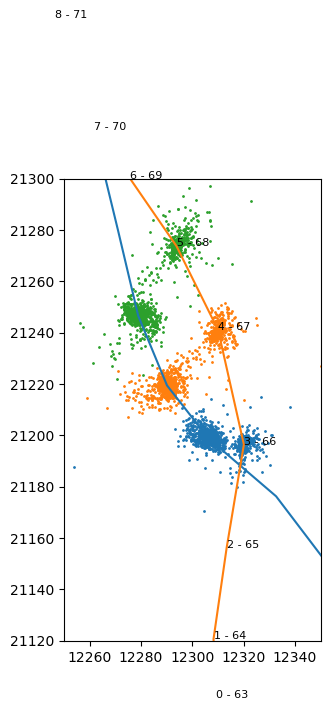

In [11]:
if buildEnv:  # 2D plot of TNG orbit and particles
    # Seperate orbit data

    # 1st three columns are primary galaxy path
    # 2nd three columns are secondary galaxy path
    # 7th column is a snapshot label

    # Narrow orbit paths to encounter of interest
    t_start = 8
    t_stop = 17
    ts = slice(t_start, t_stop)
    p_orbit = tng_data['orbit'][ts,0:6]
    s_orbit = tng_data['orbit'][ts,6:12]
    p_orbit_full = tng_data['orbit'][:,0:6]
    s_orbit_full = tng_data['orbit'][:,6:12]
    snaps = tng_data['orbit'][ts,12]
    snaps_full = tng_data['orbit'][:,12]
    times = np.array([ tf.snap_to_time(snap) for snap in snaps ])
    times_full = np.array([ tf.snap_to_time(snap) for snap in snaps_full ])

    # Plot orbit
    fig, ax = plt.subplots(1,1)
    ax.plot(p_orbit[:,0], p_orbit[:,1], label='Primary')
    ax.plot(s_orbit[:,0], s_orbit[:,1], label='Secondary')


    # Add timesteps label to secondary galaxy
    for i in range(0, len(snaps)):
        ax.text(s_orbit[i,0], s_orbit[i,1], f"{i} - {str(int(snaps[i]))}", fontsize=8)

    # plot particles
    n_plot = 2000

    for i in range(3):
        # Get size of simulation points
        n = tng_data[i]['pts'].shape[0]
        # Choose n_plot random points
        idx = np.random.choice(n, n_plot, replace=False)
        # scatter plot points
        ax.scatter(tng_data[i]['pts'][idx,0], tng_data[i]['pts'][idx,1], s=1, label=f"Snap {tng_data[i]['snapnum']}")
        
    # Set range of plot
    ax.set_xlim(12250, 12350)
    ax.set_ylim(21120, 21300)

    # Set square aspect ratio
    ax.set_aspect('equal', 'box')

    # Set figure size
    fig.set_size_inches(4,6)


In [12]:
if buildEnv and False: # 3D Plot of above

    pt_labels = []
    pt_all = []
    
    for i in range(3):
        # grab 1000 random points to plot
        n_plot = 1000
        n = tng_data[i]['pts'].shape[0]
        idx = np.random.choice(n, n_plot, replace=False)
        pt_all.append(tng_data[i]['pts'][idx])
        pt_labels += [i] * n_plot

    pt_all = np.vstack(pt_all)
    pt_labels = np.array(pt_labels)

    tf.interactive_3d_scatter_plot( xyz_pts = pt_all, pt_labels=pt_labels, \
                                   plot_lines = [p_orbit, s_orbit], plot_labels = ['Primary', 'Secondary'], \
                                    sig_pts = s_orbit, sig_labels = snaps, \
                                    title="Orbit of Primary and Secondary Galaxies")

## Misc Functions

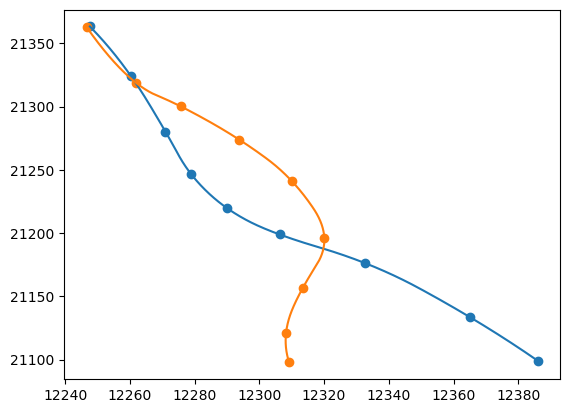

In [ ]:
def generate_spline_points(times, orbit, s_type = 'quadratic'):
    """
    Perform quadratic spline interpolation for given positions.

    Args:
    - times (np.ndarray): Array of times.
    - orbit (np.ndarray): Array of positions and velocites. [x, y, z, vx, vy, vz]
    - s_type (str): Type of spline interpolation ('quadratic' or 'cubic').


    Returns:
    - spline orbit (np.ndarray): Array of positions along spline of orbit . [x, y, z]
    """
    from scipy.interpolate import interp1d, CubicHermiteSpline

    # Validate the kind parameter
    if kind not in ['quadratic', 'cubic']:
        raise ValueError("Parameter 'kind' must be either 'quadratic' or 'cubic'.")

    if s_type == 'quadratic':
        interp = interp1d
    elif s_type == 'cubic':
        interp = CubicHermiteSpline

    # Ensure inputs are numpy arrays
    times = np.asarray(times)
    positions = np.asarray(orbit[:, :3])
    velocities = np.asarray( orbit[:, 3:6] )

    if s_type == 'quadratic':
        # Create a quadratic spline for each dimension
        splines = [interp1d(times, positions[:, i], kind='quadratic') for i in range(3)]

    elif s_type == 'cubic':
        # Create a cubic spline for each dimension
        splines = [CubicHermiteSpline(times, positions[:, i], velocities[:, i]) for i in range(3)]

    # Evaluate n pts along splines
    n_pts = 1000
    s_times = np.linspace(times[0], times[-1], n_pts)
    spline_orbit = np.zeros((n_pts, 3))
    for i in range(3):
        spline_orbit[:, i] = splines[i](s_times)
    
    return spline_orbit


if buildEnv:
    p_spline = generate_quad_spline_points( times, p_orbit )
    s_spline = generate_quad_spline_points( times, s_orbit )

    fig, ax = plt.subplots(1,1)
    ax.plot(p_spline[:,0], p_spline[:,1], label='Primary Spline')
    ax.scatter(p_orbit[:,0], p_orbit[:,1], label='Primary Orbit')

    ax.plot(s_spline[:,0], s_spline[:,1], label='Secondary Spline')
    ax.scatter(s_orbit[:,0], s_orbit[:,1], label='Secondary Orbit')

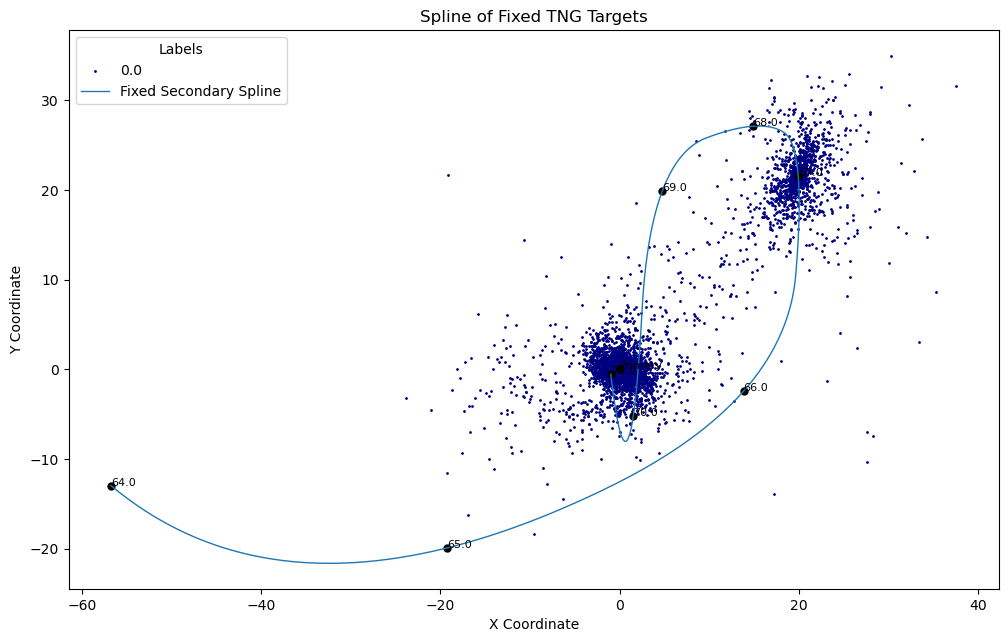

In [14]:
def convert_to_fixed_frame(primary, secondary):
    """
    Convert the orbital paths and velocities to a frame where the primary galaxy is fixed at the origin.

    Args:
    - primary (np.ndarray): Nx6 array of primary galaxy positions and velocities [ x y z vy vy vz ].
    - secondary (np.ndarray): Nx6 array of secondary galaxy positions and velocities [ x y z vy vy vz ].

    Returns:
    - fixed_secondary (np.ndarray): Nx6 array of secondary galaxy positions and velocities in the fixed frame.
    """
    # Ensure the input arrays have the correct shape
    assert primary.shape == secondary.shape

    # Convert to fixed frame
    fixed_secondary = secondary - primary

    return fixed_secondary


def convert_to_moving_frame(primary_moving, secondary_fixed):
    """
    Convert the paths and velocities from a fixed primary frame back to the original moving frame.

    Args:
    - primary_moving (np.ndarray): Nx6 array of primary galaxy positions and velocities [x, y, z, vx, vy, vz].
    - secondary_fixed (np.ndarray): Nx6 array of secondary galaxy positions and velocities in the fixed frame.

    Returns:
    - secondary_moving (np.ndarray): Nx6 array of secondary galaxy positions and velocities in the moving frame.
    """
    # Ensure the input arrays have the correct shape
    assert primary_moving.shape == secondary_fixed.shape, "Primary and fixed secondary arrays must have the same shape"
    assert primary_moving.shape[1] == 6, "Each row should contain 6 elements: [x, y, z, vx, vy, vz]"

    # Convert to moving frame
    secondary_moving = secondary_fixed + primary_moving

    return secondary_moving

def convert_pts_to_fixed_frame( primary_pos, pts ):
    """
    Convert the points to a frame where the primary galaxy center is fixed at the origin.

    Args:
    - primary_pos (np.ndarray): 3 array of primary galaxy positions and velocities [ x y z ].
    - pts (np.ndarray): Nx3 array of secondary galaxy positions and velocities [ x y z].

    Returns:
    - fixed_pts (np.ndarray): Nx6 array of secondary galaxy positions and velocities in the fixed frame.
    """
    # Ensure the input arrays have the correct shape
    assert primary_pos.shape[0] == 3, "Primary position array should contain 3 elements: [x, y, z]"
    assert pts.shape[1] == 3, "Each row should contain 3 elements: [x, y, z]"

    # Convert to fixed frame
    fixed_pts = pts - primary_pos

    return fixed_pts

if True:
    
    # Narrow orbit paths to encounter of interest
    t_start = 9
    t_stop = -3
    ts = slice(t_start, t_stop)
    p_orbit = tng_data['orbit'][ts, 0:6]
    s_orbit = tng_data['orbit'][ts, 6:12]
    snaps = tng_data['orbit'][ts, 12]
    times = np.array([tf.snap_to_time(snap) for snap in snaps])

    # Convert to fixed frame
    s_orbit_fixed = convert_to_fixed_frame(p_orbit, s_orbit)

    # Create spline of fixes orbit 
    s_spline_pts_fixed = generate_quad_spline_points(times, s_orbit_fixed)

    # Add some pts 
    n_plot = 5000
    n = tng_data[1]['pts'].shape[0]
    idx = np.random.choice(n, n_plot, replace=False)
    pts = tng_data[1]['pts'][idx,0:3]
    pts_fixed = convert_pts_to_fixed_frame(p_orbit[3, 0:3], pts)

    # Add origin to sig_pts
    sig_pts = s_orbit_fixed[:,0:3]
    sig_pts = np.vstack( (sig_pts, np.zeros((1,3)) ) )

    # print( sig_pts )

    sig_labels = snaps.tolist()
    sig_labels.append( 'Primary')

    # print( sig_labels )

    # Plot the fixed and moving secondary galaxy orbits
    tf.xy_scatter_plot( \
        xy_pts = pts_fixed,  \
        plot_lines = s_spline_pts_fixed, plot_labels = ['Fixed Secondary Spline',], \
        sig_pts=sig_pts, sig_labels=sig_labels, title='Spline of Fixed TNG Targets', figsize=(12,8))

In [15]:
# reload tf
if buildEnv:
    import importlib
    tf = importlib.reload(tf)
    sim = importlib.reload(sim)

---
## Let's run the TNG parameters through SPAM

### Plot Orbits and Location of closest approach

SPAM orbit: (3748, 3)


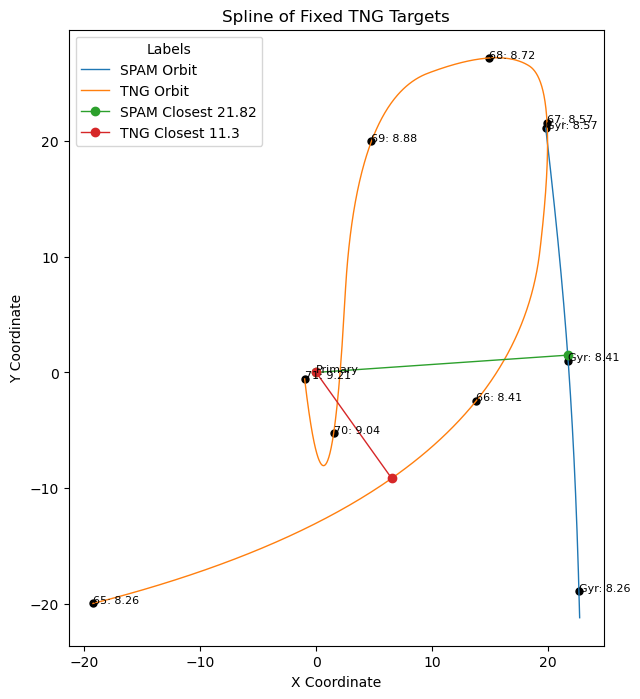

In [16]:
def plot_spam_orbit( test_spam_ar, df_val=0.001 ):  # Plot orbits

    spam_orbit_raw = sim.orbit_run_wrapper( test_spam_ar, dynamic_friction_lnl=df_val )
    spam_orbit_tng_pos = convert_distance_spam_to_tng(spam_orbit_raw[:,0:3])

    print(f"SPAM orbit: {spam_orbit_tng_pos.shape}")

    # Find point along orbit closest to origin
    origin = np.zeros(3)
    dists = np.linalg.norm(spam_orbit_tng_pos - origin, axis=1)
    idx = np.argmin(dists)

    # create 2x3 vector of starting and stopping point between origiin and closest point
    spam_closest = np.vstack((origin, spam_orbit_tng_pos[idx]))
    
    # Narrow orbit paths to time of interest
    t_start = 10
    t_stop = -3
    ts = slice(t_start, t_stop)
    p_orbit = tng_data['orbit'][ts, 0:6]
    s_orbit = tng_data['orbit'][ts, 6:12]
    snaps = tng_data['orbit'][ts, 12]
    times = np.array([tf.snap_to_time(snap) for snap in snaps])

    # Create list of strings for snap + time
    snap_times = [f"{int(snaps[i])}: {times[i]:.2f}" for i in range(len(snaps))]

    # Convert to fixed frame
    s_orbit_fixed = convert_to_fixed_frame(p_orbit, s_orbit)

    # Create spline of fixes orbit 
    s_spline_pts_fixed = generate_quad_spline_points(times, s_orbit_fixed)

    # Find vector of closest point to origin along orbit 
    dists = np.linalg.norm(s_spline_pts_fixed[:500,0:3] - origin, axis=1)
    idx = np.argmin(dists)

    # create 2x3 vector of starting and stopping point
    tng_closest = np.vstack((origin, s_spline_pts_fixed[idx]))

    # Find index that matches current snapnum
    current_snapnum = 67
    idx = np.where( snaps == current_snapnum )[0][0]

    # Get snaps earlier than current snap
    snaps_i = np.where( snaps <= current_snapnum )[0]

    # Get times from SPAM orbit
    spam_times = spam_orbit_raw[:,-1]

    # Set final time as 0
    spam_times -= spam_times[-1]

    # Convert to TNG times
    spam_times = convert_time_spam_to_tng(spam_times)

    # Add TNG offset 
    spam_times += times[idx]

    # Get locations in spam_times that most closely matches times[snaps_i]
    spam_i = np.zeros(len(snaps_i), dtype=int)
    for i in range(len(snaps_i)):
        spam_i[i] = np.argmin( np.abs( spam_times - times[snaps_i[i]] ) )
    
    # Add plots of interest
    plot_list = []
    plot_titles = []

    plot_list.append( spam_orbit_tng_pos )
    plot_titles.append( 'SPAM Orbit' )

    plot_list.append( s_spline_pts_fixed )
    plot_titles.append( 'TNG Orbit' )

    # Add Points of interest

    # Add TNG snap points
    sig_pts = s_orbit_fixed[:,0:3]
    sig_labels = snap_times

    # Add primary galaxy as origin
    sig_pts = np.vstack( (sig_pts, np.zeros((1,3)) ) )
    sig_labels.append( 'Primary')

    # Add spam_i in orbit to significant points
    sig_pts = np.vstack( (sig_pts, spam_orbit_tng_pos[spam_i]) )
    sig_labels += ["Gyr: %.2f" % spam_times[i] for i in spam_i]

    # Add vectors of interest,  create n x 2 x 3 array
    vectors = np.array([ spam_closest, tng_closest ])
    vector_labels = ['SPAM Closest %.2f'%np.linalg.norm(spam_closest[1]), 'TNG Closest %.1f'%np.linalg.norm(tng_closest[1])]

    # Plot the fixed and moving secondary galaxy orbits
    tf.xy_scatter_plot( plot_lines = plot_list, plot_labels = plot_titles, \
                        sig_pts=sig_pts, sig_labels=sig_labels, \
                        vector_list = vectors, vector_labels = vector_labels, \
                        title='Spline of Fixed TNG Targets', figsize=(12,8))

if buildEnv:
    
    # Grab target for particle data
    uidRaw = 67000000350284
    test_target = tng_targets[tng_targets['moi_SubhaloIDRaw'] == uidRaw].iloc[0]

    test_tng_ar1 = standardize_tng_parameters_v1( test_target )
    test_spam_ar1 = convert_units_tng_to_spam_v1( test_tng_ar1 )

    # test_spam_ar[3:6] *= 2.5 # Increase vel
    # test_spam_ar[8:10] *= 40.0  # Increase radius
    #print(test_spam_ar)
    
    plot_spam_orbit( test_spam_ar1 )

### Let's plot some particles!

SPAM Orbit: (2664, 3)
SPAM Pts: (5001, 3)


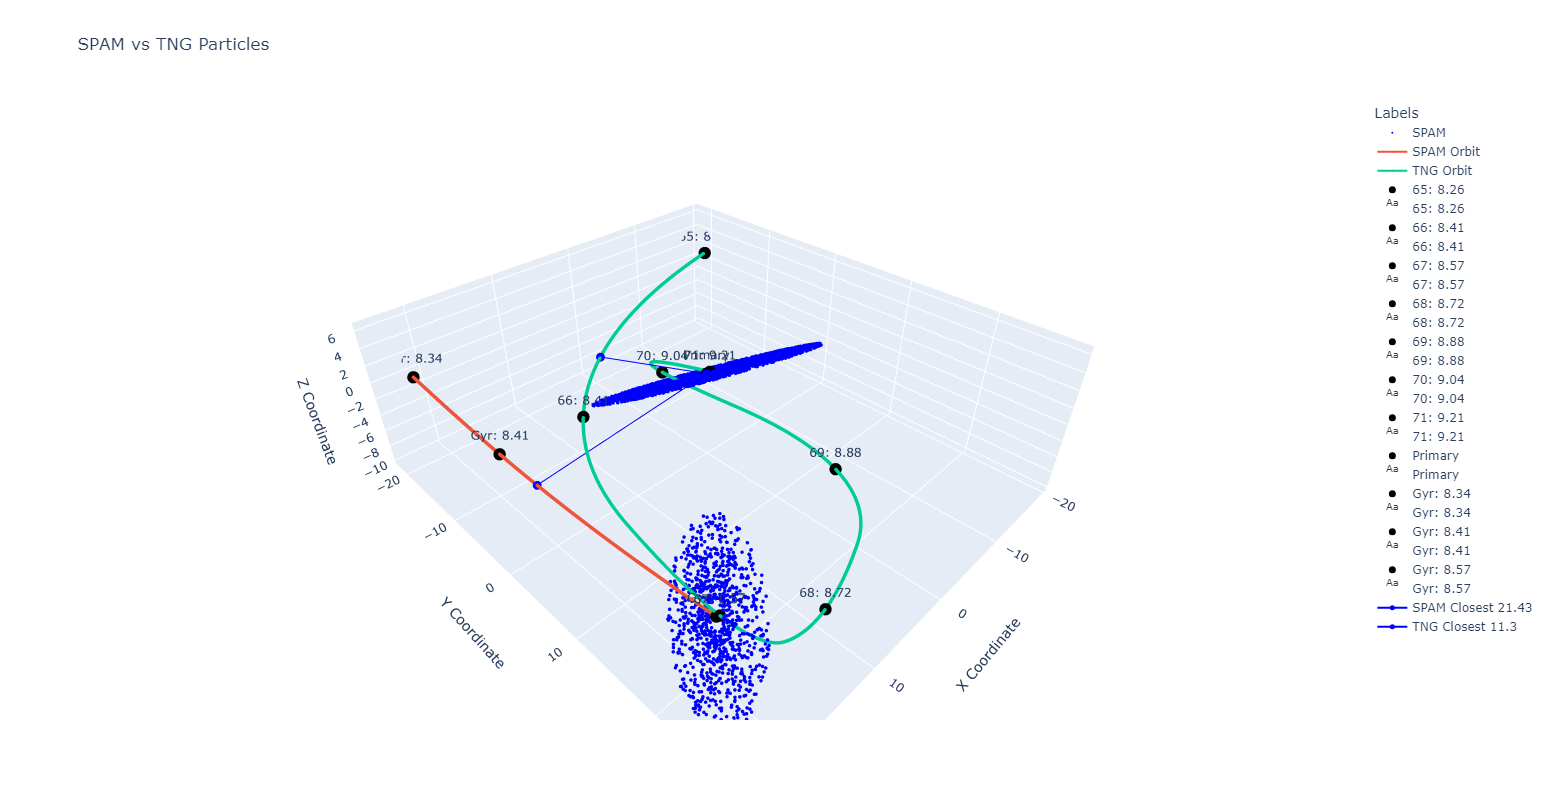

In [17]:
def plot_spam_pts( test_spam_ar, df_val=0.001 ):  # Plot particles

    ###### Perform SPAM simulation   #####

    spam_orbit_raw = sim.orbit_run_wrapper( test_spam_ar, dynamic_friction_lnl=df_val )
    spam_orbit_tng_pos = convert_distance_spam_to_tng(spam_orbit_raw[:,0:3])

    spam_ipts, spam_fpts = sim.basic_run_wrapper( test_spam_ar, 4000, 1000, dynamic_friction_lnl=df_val)
    spam_fpts = convert_distance_spam_to_tng(spam_fpts[:,0:3])

    print(f"SPAM Orbit: {spam_orbit_tng_pos.shape}")
    print(f"SPAM Pts: {spam_fpts.shape}")

    # Find point of closest approach to origin
    origin = np.zeros(3)
    dists = np.linalg.norm(spam_orbit_tng_pos - origin, axis=1)
    idx = np.argmin(dists)

    # create 2x3 vector of starting and stopping point between origiin and closest point
    spam_closest = np.vstack((origin, spam_orbit_tng_pos[idx]))
    
    #####   Grab TNG Data   #####

    # Narrow orbit paths to time of interest
    t_start = 10
    t_stop = -3
    ts = slice(t_start, t_stop)
    p_orbit = tng_data['orbit'][ts, 0:6]
    s_orbit = tng_data['orbit'][ts, 6:12]
    snaps = tng_data['orbit'][ts, 12]
    times = np.array([tf.snap_to_time(snap) for snap in snaps])

    # Create list of strings for snap + time
    snap_times = [f"{int(snaps[i])}: {times[i]:.2f}" for i in range(len(snaps))]

    # Convert to fixed frame
    s_orbit_fixed = convert_to_fixed_frame(p_orbit, s_orbit)

    # Create spline of fixes orbit 
    s_spline_pts_fixed = generate_quad_spline_points(times, s_orbit_fixed)

    # Find vector of closest point to origin along orbit 
    dists = np.linalg.norm(s_spline_pts_fixed[:500,0:3] - origin, axis=1)
    idx = np.argmin(dists)

    # create 2x3 vector of starting and stopping point
    tng_closest = np.vstack((origin, s_spline_pts_fixed[idx]))

    # define N pts for plotting
    n_pts = 4000
    # Get size of simulation points
    n = tng_data[1]['pts'].shape[0]
    # Choose n_pts random points
    idx = np.random.choice(n, n_pts, replace=False)
    tng_pts = tng_data[1]['pts'][idx,0:3]
    tng_pts = convert_pts_to_fixed_frame( p_orbit[2, 0:3], tng_pts)

    #####   MATCH TIMES BETWEEN SIMULATIONS   #####

    # Find index that matches current snapnum
    current_snapnum = 67
    idx = np.where( snaps == current_snapnum )[0][0]

    # Get snaps earlier than current snap
    snaps_i = np.where( snaps <= current_snapnum )[0]

    # Get times from SPAM orbit
    spam_times = spam_orbit_raw[:,-1]

    # Set final time as 0
    spam_times -= spam_times[-1]

    # Convert to TNG times
    spam_times = convert_time_spam_to_tng(spam_times)

    # Add TNG offset 
    spam_times += times[idx]

    # Get locations in spam_times that most closely matches times[snaps_i]
    spam_i = np.zeros(len(snaps_i), dtype=int)
    for i in range(len(snaps_i)):
        spam_i[i] = np.argmin( np.abs( spam_times - times[snaps_i[i]] ) )
    
    #####  Gather Data for PLOTTING   #####

    # Add scatter pts of interest
    pts_list = np.vstack( ( spam_fpts, tng_pts ) )

    # Create an array of strings of the same length
    spam_labels = np.array(['SPAM'] * len(spam_fpts))
    tng_labels = np.array(['TNG'] * len(tng_pts))
    pt_labels = np.hstack( (spam_labels, tng_labels) )

    # Add plots(lines) of interest
    plot_list = []
    plot_titles = []

    plot_list.append( spam_orbit_tng_pos )
    plot_titles.append( 'SPAM Orbit' )

    plot_list.append( s_spline_pts_fixed )
    plot_titles.append( 'TNG Orbit' )

    # Add Significant Points of interest

    # Add TNG snap points
    sig_pts = s_orbit_fixed[:,0:3]
    sig_labels = snap_times

    # Add primary galaxy as origin
    sig_pts = np.vstack( (sig_pts, np.zeros((1,3)) ) )
    sig_labels.append( 'Primary')

    # Add spam_i in orbit to significant points
    sig_pts = np.vstack( (sig_pts, spam_orbit_tng_pos[spam_i]) )
    sig_labels += ["Gyr: %.2f" % spam_times[i] for i in spam_i]

    # Add vectors of interest,  create n x 2 x 3 array
    vectors = np.array([ spam_closest, tng_closest ])
    vector_labels = ['SPAM Closest %.2f'%np.linalg.norm(spam_closest[1]), 'TNG Closest %.1f'%np.linalg.norm(tng_closest[1])]

    tf.interactive_3d_scatter_plot( 
        xyz_pts = spam_fpts, pt_labels = spam_labels, \
        plot_lines = plot_list, plot_labels = plot_titles, \
        sig_pts=sig_pts, sig_labels=sig_labels, \
        vector_list = vectors, vector_labels = vector_labels, \
        title='SPAM vs TNG Particles')

    # # Plot the fixed and moving secondary galaxy orbits
    # tf.xy_scatter_plot( \
    #     xy_pts = tng_pts, pt_labels = tng_labels, \
    #     plot_lines = plot_list, plot_labels = plot_titles, \
    #     sig_pts=sig_pts, sig_labels=sig_labels, \
    #     vector_list = vectors, vector_labels = vector_labels, \
    #     title='TNG Particles', figsize=(12,8))
    
    # # Plot the fixed and moving secondary galaxy orbits
    # tf.xy_scatter_plot( \
    #     xy_pts = spam_fpts, pt_labels = spam_labels, \
    #     plot_lines = plot_list, plot_labels = plot_titles, \
    #     sig_pts=sig_pts, sig_labels=sig_labels, \
    #     vector_list = vectors, vector_labels = vector_labels, \
    #     title='SPAM Particles', figsize=(12,8))

if buildEnv:

    # Grab target for particle data
    uidRaw = 67000000350284
    test_target = tng_targets[tng_targets['moi_SubhaloIDRaw'] == uidRaw].iloc[0]

    test_tng_ar2 = standardize_tng_parameters_v1( test_target )
    test_spam_ar2 = convert_units_tng_to_spam_v1( test_tng_ar2 )

    # test_spam_ar2[3:6] *= 2.5 # Increase vel
    test_spam_ar2[8] *= 2.2  # Increase radius of primary
    test_spam_ar2[6] *= 2.9  # Increase mass of primary
    test_spam_ar2[7] *= 2.2  # Increase mass of secondary
    # test_spam_ar2[]
    # print(test_spam_ar)

    # Using lnl that looked good to me above.
    lnl = 0.2

    plot_spam_pts( test_spam_ar2, lnl )


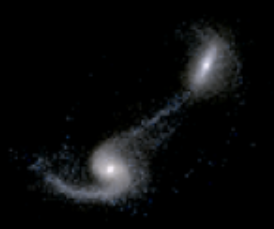

## Mismatch between Orbits and Particles.

The orbits (and velocities) are not matching up.  
- NOTE: SPAM "orbits" around primary multiple times without falling towards it much.  TNG should be a more realistic simulation, and it shows the secondary falling towards the primary almost immediately after the 2st fly by event. 

- [x] Modify the "strength" of Dynamic Friction.  TNG appears to have MUCH stronger dynamic friction.
  - [x] Find lnl in SPAM code.
    - RESULTS: Turns out I wasn't using DF (dynamical friction) as expected, I hardcoded the wrong variable in custom runs
  - [x] Write variable to change lnl in SPAM code.
  - [x] Do grid search to find best lnl value.
    - RESULTS: Found a lnl values that allows SPAM to overlap the TNG orbit increibly well.  But... 
      - Now Velocity is now extremely off....  SPAM is going faster than it should be
      - Particles are forming correct tidal features, but haven't had enough time to form them...  

- [x] Vary velocity: Grid search
  - RESULTS:  Varying the velocity also produced an orbit that causing good overlap.  But...
    - Same problems as above.  Vel is too fast and particles need more time to form tidal features.  

- [x] Verify correct velocity/unit coversion between TNG and SPAM
  - [x] Create custom module of just velocity over time for 2nd gal.
  - RESULTS: Velocity (unit conversion) looks correct.  TNG is slightly faster (in the past), meaning DF is slowing it down as expected.

- [x] Identify purpose of rscale.  This could affect mass distribution around galaxy and affect particle tidal distortions
  - [x] FOUND: They only affect how particles are originally placed.  We want it hardcoded at 1/r which doesn't use rscales.
  
- [ ] Vary mass: grid search


### Plot Velocity/Position Test

 FR: Testing Position and Velocity!
SPAM orbit: (5000, 3)


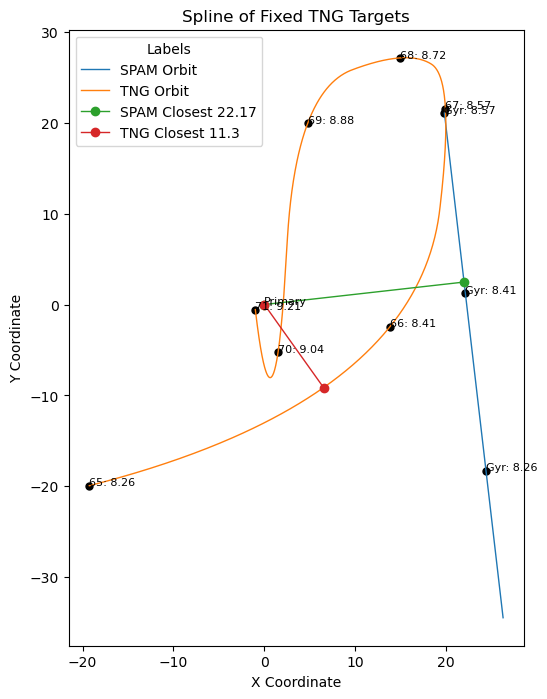

In [18]:
def plot_spam_orbit( test_spam_ar,  ):
    pass

if buildEnv:

    import importlib

    importlib.reload(sim)
    
    # Grab target for particle data
    uidRaw = 67000000350284
    test_target = tng_targets[tng_targets['moi_SubhaloIDRaw'] == uidRaw].iloc[0]

    test_tng_ar1 = standardize_tng_parameters_v1( test_target )
    test_spam_ar1 = convert_units_tng_to_spam_v1( test_tng_ar1 )

    # test_spam_ar[3:6] *= 2.5 # Increase vel
    # test_spam_ar[8:10] *= 40.0  # Increase radius
    #print(test_spam_ar)
        
    df_val=0.001
    spam_orbit_raw = sim.testing_pos_vel_wrapper( test_spam_ar1, 5000 )
    spam_orbit_tng_pos = convert_distance_spam_to_tng(spam_orbit_raw[:,0:3])

    print(f"SPAM orbit: {spam_orbit_tng_pos.shape}")

    # Find point along orbit closest to origin
    origin = np.zeros(3)
    dists = np.linalg.norm(spam_orbit_tng_pos - origin, axis=1)
    idx = np.argmin(dists)

    # create 2x3 vector of starting and stopping point between origiin and closest point
    spam_closest = np.vstack((origin, spam_orbit_tng_pos[idx]))
    
    # Narrow orbit paths to time of interest
    t_start = 10
    t_stop = -3
    ts = slice(t_start, t_stop)
    p_orbit = tng_data['orbit'][ts, 0:6]
    s_orbit = tng_data['orbit'][ts, 6:12]
    snaps = tng_data['orbit'][ts, 12]
    times = np.array([tf.snap_to_time(snap) for snap in snaps])

    # Create list of strings for snap + time
    snap_times = [f"{int(snaps[i])}: {times[i]:.2f}" for i in range(len(snaps))]

    # Convert to fixed frame
    s_orbit_fixed = convert_to_fixed_frame(p_orbit, s_orbit)

    # Create spline of fixes orbit 
    s_spline_pts_fixed = generate_quad_spline_points(times, s_orbit_fixed)

    # Find vector of closest point to origin along orbit 
    dists = np.linalg.norm(s_spline_pts_fixed[:500,0:3] - origin, axis=1)
    idx = np.argmin(dists)

    # create 2x3 vector of starting and stopping point
    tng_closest = np.vstack((origin, s_spline_pts_fixed[idx]))

    # Find index that matches current snapnum
    current_snapnum = 67
    idx = np.where( snaps == current_snapnum )[0][0]

    # Get snaps earlier than current snap
    snaps_i = np.where( snaps <= current_snapnum )[0]

    # Get times from SPAM orbit
    spam_times = spam_orbit_raw[:,-1]

    # Set final time as 0
    spam_times -= spam_times[-1]

    # Convert to TNG times
    spam_times = convert_time_spam_to_tng(spam_times)

    # Add TNG offset 
    spam_times += times[idx]

    # Get locations in spam_times that most closely matches times[snaps_i]
    spam_i = np.zeros(len(snaps_i), dtype=int)
    for i in range(len(snaps_i)):
        spam_i[i] = np.argmin( np.abs( spam_times - times[snaps_i[i]] ) )
    
    # Add plots of interest
    plot_list = []
    plot_titles = []

    plot_list.append( spam_orbit_tng_pos )
    plot_titles.append( 'SPAM Orbit' )

    plot_list.append( s_spline_pts_fixed )
    plot_titles.append( 'TNG Orbit' )

    # Add Points of interest

    # Add TNG snap points
    sig_pts = s_orbit_fixed[:,0:3]
    sig_labels = snap_times

    # Add primary galaxy as origin
    sig_pts = np.vstack( (sig_pts, np.zeros((1,3)) ) )
    sig_labels.append( 'Primary')

    # Add spam_i in orbit to significant points
    sig_pts = np.vstack( (sig_pts, spam_orbit_tng_pos[spam_i]) )
    sig_labels += ["Gyr: %.2f" % spam_times[i] for i in spam_i]

    # Add vectors of interest,  create n x 2 x 3 array
    vectors = np.array([ spam_closest, tng_closest ])
    vector_labels = ['SPAM Closest %.2f'%np.linalg.norm(spam_closest[1]), 'TNG Closest %.1f'%np.linalg.norm(tng_closest[1])]

    # Plot the fixed and moving secondary galaxy orbits
    tf.xy_scatter_plot( plot_lines = plot_list, plot_labels = plot_titles, \
                        sig_pts=sig_pts, sig_labels=sig_labels, \
                        vector_list = vectors, vector_labels = vector_labels, \
                        title='Spline of Fixed TNG Targets', figsize=(12,8))

In [19]:
if buildEnv and False:  # DF (lnl) Grid search
    
    # Perform grid search between 0.001 and 100
    # lnl_vals = np.logspace(-3, 2, 5)
    # Perform grid search between 0.1 and 1
    lnl_vals = np.linspace(0.1, 1, 5 )
    # Perform grid search between 0.1 and 0.2
    # lnl_vals = np.linspace(0.1, 0.2, 5)
    for i, lnl in enumerate(lnl_vals):
        print(f"#####   LNL: {lnl}   #####")
        print( i, lnl )
        test_orbit_param = test_spam_ar1.copy()
        # test_orbit_param[3:6] *= 0.02     
        plot_spam_orbit( test_orbit_param, df_val=lnl )


: 

### Optimization!

Because I don't want to do manual grid searches anymore, let's optimize!  I believe the orbit is primarily affected by three things, velocity, mass, and dynamical friction.  So let's vary lnl and add two new mass and velocity scaling constants. 

In [20]:
from scipy.optimize import minimize

def percentage_difference(value1, value2):
    return np.abs(value1 - value2) / np.abs(value2)

def run_spam_simulation(c_mass, c_vel, lnl, spam_ar):

    # Modify variables based on scales
    mod_spam_ar = spam_ar.copy()
    mod_spam_ar[3:6] *= c_vel
    mod_spam_ar[6:7] *= c_mass
    # test_spam_ar[8:10] *= 40.0  # Increase radius
    
    spam_orbit_raw = sim.orbit_run_wrapper( mod_spam_ar, dynamic_friction_lnl=lnl )
    
    return spam_orbit_raw

def objective_function( params, tng_cmp, spam_ar ):

    # Scales for importance of each metric
    time_s = 5.0
    pos_s = 1.0
    vel_s = 0.5
    
    c_mass, c_vel, lnl = params
    tng_orbit, tng_snaps, tng_times, tng_time_offset = tng_cmp
    spam_orbit_raw = run_spam_simulation(c_mass, c_vel, lnl, spam_ar)
    spam_orbit_tng_pos = convert_distance_spam_to_tng(spam_orbit_raw[:,0:3])
    spam_orbit_tng_vel = convert_velocity_spam_to_tng(spam_orbit_raw[:,3:6])

    # Get times from orbit simulation
    spam_orbit_times = spam_orbit_raw[:,-1]
    # Set final time as 0
    spam_orbit_times -= spam_orbit_times[-1]
    # Convert to TNG times
    spam_orbit_times = convert_time_spam_to_tng(spam_orbit_times)
    # Add time offset
    spam_orbit_times += tng_time_offset

    # print( spam_orbit_times)

    # Get locations in spam_times that most closely matches tng times
    spam_i = np.zeros(len(tng_snaps), dtype=int)
    for i in range(len(tng_snaps)):
        spam_i[i] = np.argmin( np.abs( spam_orbit_times - tng_times[i] ) )

    # print(spam_i)

    # Loop through each snap and score the difference

    score = 0.0

    for i in range(len(tng_snaps)):
        
        snap = tng_snaps[i]
        time = tng_times[i]
        spam_time = spam_orbit_times[spam_i[i]]

        tng_loc = tng_orbit[i,0:3]
        spam_loc = spam_orbit_tng_pos[spam_i[i],0:3]

        tng_vel = tng_orbit[i,3:6]
        spam_vel = spam_orbit_tng_vel[spam_i[i],0:3]


        # print( f"Snap: {snap}, TNG Time: {time:.2f}, SPAM Time: {spam_time}" )

        # We want to minimize this funciton.  Therefore 0 is good, anything above is bad
        # Let's do percent difference!
        # Comparing position and time for snapshot before moment of interest
        pos_diff = percentage_difference(tng_loc, spam_loc)
        time_diff = percentage_difference(time, spam_time)
        vel_diff = percentage_difference(tng_vel, spam_vel)


        score += time_s * np.mean(time_diff) + pos_s * np.mean(pos_diff) + vel_s * np.mean(vel_diff)

        # print(f"Time Diff: {time_diff}, Pos Diff: {pos_diff}, Vel Diff: {vel_diff}")
        print(f"Score: {score} - Param {params}")

    return score

if buildEnv:
    
    # Grab target from TNG targets
    uidRaw = 67000000350284
    test_target = tng_targets[tng_targets['moi_SubhaloIDRaw'] == uidRaw].iloc[0]

    test_tng_ar2 = standardize_tng_parameters_v1( test_target )
    test_spam_ar2 = convert_units_tng_to_spam_v1( test_tng_ar2 )
    

    
    # TNG moments to compare to SPAM
    t_start = 11
    t_stop = 12
    ts = slice(t_start, t_stop)
    p_orbit = tng_data['orbit'][ts, 0:6]
    s_orbit = tng_data['orbit'][ts, 6:12]
    tng_snaps = tng_data['orbit'][ts, 12]
    tng_times = np.array([tf.snap_to_time(snap) for snap in snaps])
    tng_time_offset = tf.snap_to_time(tng_data['orbit'][12,12])
    print( tng_time_offset)

    # Create list of strings for snap + time
    snap_times = [f"{int(snaps[i])}: {times[i]:.2f}" for i in range(len(tng_snaps))]

    print( snap_times)

    # Convert to fixed frame
    tng_orbit = convert_to_fixed_frame(p_orbit, s_orbit)

    # Prepare for optimization
    init_guess = [1.0, 1.0, 0.1]
    tng_cmp = [tng_orbit, tng_snaps, tng_times, tng_time_offset]

    # Test objective_function
    # objective_function( init_guess, tng_cmp, test_spam_ar2 )

    # Run optimization
    result = minimize(objective_function, init_guess, args=(tng_cmp, test_spam_ar2), tol=1e-4)

    # Optimal parameters
    optimal_params = result.x
    c_mass_opt, c_vel_opt, lnl_opt = optimal_params

    print("Optimal parameters:")
    print("c_mass:", c_mass_opt)
    print("c_vel:", c_vel_opt)
    print("lnl:", lnl_opt)
    


8.568424666074142
['65: 8.26']
Score: 4.1439456482557135 - Param [1.  1.  0.1]
Score: 4.143945701240515 - Param [1.00000001 1.         0.1       ]
Score: 4.143945593068376 - Param [1.         1.00000001 0.1       ]
Score: 4.143945518674128 - Param [1.         1.         0.10000001]
Score: 2.288225288325094 - Param [0.64437515 1.37040789 0.96972925]
Score: 2.288225292298308 - Param [0.64437517 1.37040789 0.96972925]
Score: 2.2882252976203086 - Param [0.64437515 1.3704079  0.96972925]
Score: 2.2882252917125117 - Param [0.64437515 1.37040789 0.96972926]
Score: 2.1588111049821745 - Param [0.27157616 0.88577162 1.02991568]
Score: 2.158811108914808 - Param [0.27157617 0.88577162 1.02991568]
Score: 2.158811108063671 - Param [0.27157616 0.88577163 1.02991568]
Score: 2.158811106285154 - Param [0.27157616 0.88577162 1.02991569]


: 

: 

SPAM orbit: (606, 3) FR: Orbit Run! lnl:   0.87704708981723145     



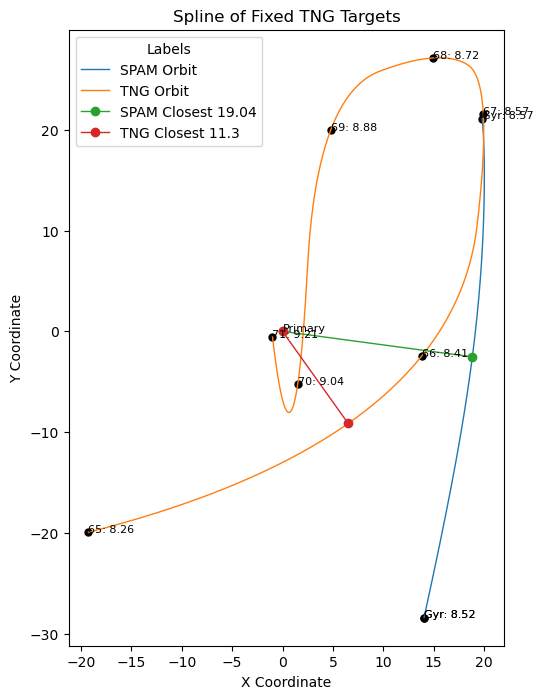

In [ ]:

    
if buildEnv:
    
    # Grab target for particle data
    uidRaw = 67000000350284
    test_target = tng_targets[tng_targets['moi_SubhaloIDRaw'] == uidRaw].iloc[0]

    tng_ar = standardize_tng_parameters_v1( test_target )
    spam_ar3 = convert_units_tng_to_spam_v1( tng_ar )

    c_mass = 1.4845669539404365
    c_vel = 1.4672694515413447
    lnl = 0.8770470898172315

    spam_ar3[3:6] *= c_vel
    spam_ar3[6:7] *= c_mass
    # test_spam_ar[8:10] *= 40.0  # Increase radius
    #print(test_spam_ar)
    
    plot_spam_orbit( spam_ar3, df_val= lnl )



 FR: Orbit Run! lnl:   0.14999999999999999     
SPAM orbit: (1532, 3)


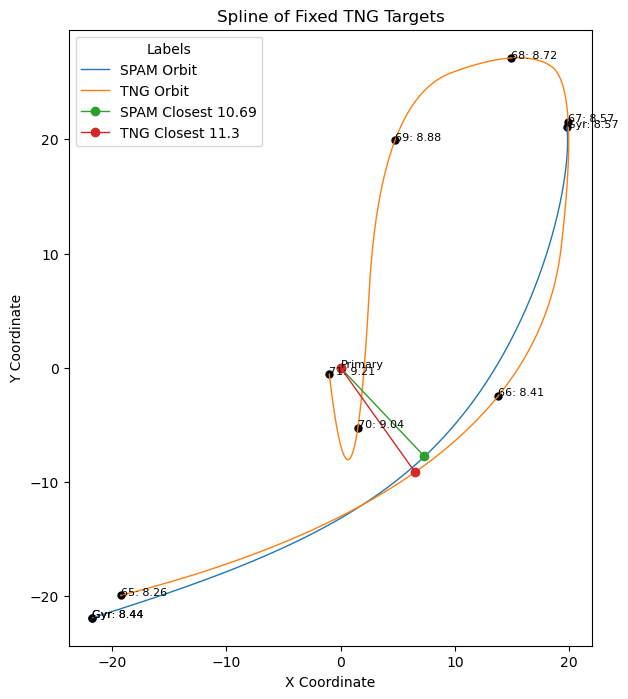

In [ ]:

    
if buildEnv:
    
    # Grab target for particle data
    uidRaw = 67000000350284
    test_target = tng_targets[tng_targets['moi_SubhaloIDRaw'] == uidRaw].iloc[0]

    tng_ar = standardize_tng_parameters_v1( test_target )
    spam_ar3 = convert_units_tng_to_spam_v1( tng_ar )

    c_mass = 1.4845669539404365
    c_vel = 1.4672694515413447
    lnl = 0.8770470898172315
    lnl = 0.15

    # spam_ar3[3:6] *= c_vel
    # spam_ar3[6:7] *= c_mass
    # test_spam_ar[8:10] *= 40.0  # Increase radius
    #print(test_spam_ar)
    
    plot_spam_orbit( spam_ar3, df_val= lnl )

